# SRIM Calculations for stopping power and energy losses for U-225 as created in Ca-48 on Hf target

The calculations are based on SRIM stopping power tables.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

from srim import SR, Ion, Layer, Target

# directory where SRIM-2013 is located
srim_executable_directory = '/home/anton/.srim/'

## Initialise parameters

In [2]:
targets = ["Hf"]
layers = []
densities = []

## Stopping materials

In [3]:
# Hf
density = 13.31e3 #mg/cm3 (from wikipedia)
densities.append(density)
# Construct a layer of Hf, arbitrary width (as it is not relevant for these calcs)
layers.append(Layer({
    'Hf': {
        'stoich': 1
        #'E_d': 35.0, # Displacement Energy
        #'lattice': 0.0,
        #'surface': 3.0
    }
}, density=1e-3*density, width=10000.0))

## Generating relevant stopping power data for U-225

In [4]:
# Construct beam
A, E_per_A_max = 225, 7e6 # nucleon number, eV 
energy_max = A*E_per_A_max
print("Max energy=", energy_max)
ion = Ion('Ca', energy=energy_max, mass=A)

f_dEdX = []
e_raw = []
e_interp = []
dEdX_raw = []

for i, layer in enumerate(layers):
    target = Target([layer])

    #output_type = 5, means MeV / (mg/cm2)
    srim = SR(layer, ion, output_type=5, energy_min=1100) 
    results = srim.run(srim_executable_directory)

    energy = 1e-3*results.data[0] #to MeV
    dEdX_raw_tmp = (results.data[1]+results.data[2])*densities[i]*1e-4 # sum of electric and nuclear stopping power and convert to MeV per µm
    proj_range = results.data[3]
    #results.units

    #interpolation of stopping power
    f_dEdX_tmp = interpolate.interp1d(energy, dEdX_raw_tmp, kind='quadratic')
    energy_interp = np.arange(np.min(energy), np.max(energy), 10)
    #print(len(energy_interp))
    f_dEdX.append(f_dEdX_tmp)
    dEdX_raw.append(dEdX_raw_tmp)
    e_raw.append(energy)
    e_interp.append(energy_interp)

Max energy= 1575000000.0


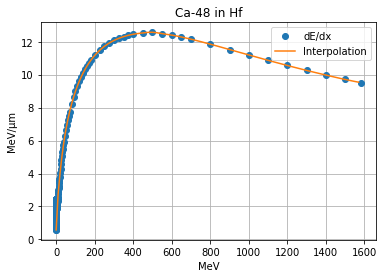

In [5]:
index = 0
plt.plot(e_raw[index], dEdX_raw[index], marker='o', label='dE/dx', linestyle='')
plt.plot(e_interp[index], f_dEdX[index](e_interp[index]), label='Interpolation')
#plt.plot(energy, results.data[2], label='Sn')
plt.legend()

plt.xlabel('MeV')
plt.ylabel('MeV/µm')
plt.title("Ca-48 in " + targets[index])
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(1e-2, 1e2)
#plt.ylim(1, None)
plt.grid()
#plt.show()

## Creating helper interpolated functions for energy losses as a function of distance 

In [6]:
E_beam_0 = 200 # MeV
step_size = 0.1 #µm
e_low_lim = 1 # MeV

e_loss = list()
x_loss = list()

f_eofxs_U225 = {}
f_xofes_U225 = {}

for i, layer in enumerate(layers):
    e, x = [], []
    x_now = 0
    E_beam = E_beam_0
    e.append(E_beam)
    x.append(x_now)
    while E_beam > e_low_lim:
        x_now += step_size
        E_beam -= f_dEdX[i](E_beam)*step_size
        e.append(E_beam)
        x.append(x_now)
    x = np.asarray(x)
    e = np.asarray(e)
    e_loss.append(e)
    x_loss.append(x)
    f_eofxs_U225[targets[i]] = (interpolate.interp1d(x, e, kind='quadratic'))
    f_xofes_U225[targets[i]] = (interpolate.interp1d(e, x, kind='quadratic'))    

In [7]:
len(layers), len(targets)

(1, 1)

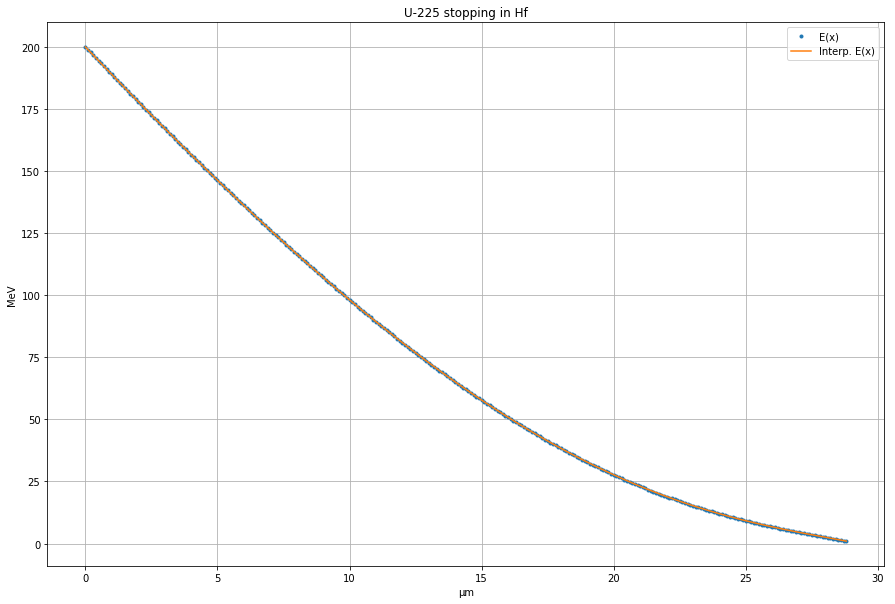

In [8]:
index = 0
target = targets[index]
plt.figure(figsize=(15,10))
plt.plot(x_loss[index], e_loss[index], marker='.', label='E(x)', linestyle='')
plt.plot(x_loss[index], f_eofxs_U225[target](x_loss[index]), marker='', label='Interp. E(x)', linestyle='-')
plt.legend()

plt.xlabel('µm')
plt.ylabel('MeV')
plt.title('U-225 stopping in '+targets[index])
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(1e-2, 1e2)
#plt.ylim(1, None)
plt.grid()
#plt.show()

Defining function to obtain the energy loss of an beam with a certain energy, traversing the material with thickness x

In [9]:
def e_loss_x_U225(E_init, x, target):
    x_start = f_xofes_U225[target](E_init)
    #print("x_start=", x_start, "x_end=", x_start+x)
    return E_init - f_eofxs_U225[target](x_start+x)

Defining function to obtain the traversed material thickness x after an energy loss of beam with a certain initial energy.

In [10]:
def x_loss_e_U225(E_init, E_after, target):
    x_start = f_xofes_U225[target](E_init)
    return f_xofes_U225[target](E_after) - x_start

In [11]:
print("SRIM calculations of U-225 successful for the following target materials:", targets)
print("\n\tCalculate energy loss as a function of traversed target material with function \'e_loss_x_U225(E_init, x, target)'")
print("\n\tCalculate traversed target material as a function of energy loss \'x_loss_e_U225(E_init, E_after, target)'")

SRIM calculations of U-225 successful for the following target materials: ['Hf']

	Calculate energy loss as a function of traversed target material with function 'e_loss_x_U225(E_init, x, target)'

	Calculate traversed target material as a function of energy loss 'x_loss_e_U225(E_init, E_after, target)'
